
### 1. Análisis y pronóstico de series de tiempo

- Seleccionar una base de datos con al menos una serie de tiempo univariada (se sugiere además considerar variables adicionales para generar un enfoque multivariado que se usará posteriormente).
- Aplicar un modelo de pronóstico **lineal clásico** (por ejemplo, SARIMAX) **solo para el caso univariado**. Recuerda usar y argumentar todo el análisis que debe ser realizado para este tipo de modelos.
- Evaluar el desempeño del modelo lineal como línea base (Usar métricas como MAPE, MSE y $R^2$).

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
df = pd.read_csv("Data/air_quality_clean.csv")
df

,Datetime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,539.0,1374.0,1729.0,21.9,29.3,0.7568
9353,2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,604.0,1264.0,1269.0,24.3,23.7,0.7119
9354,2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,603.0,1241.0,1092.0,26.9,18.3,0.6406
9355,2005-04-04 13:00:00,2.1,1003.0,9.5,961.0,702.0,1041.0,770.0,28.3,13.5,0.5139


## Modelo lineal básico

In [3]:
# Seleccionar la serie univariada
series = df['CO(GT)']

In [4]:
# Separar train y test
train_size = int(len(series) * 0.8) # 80% para train
train, test = series[:train_size], series[train_size:]

In [101]:
# Ajustar modelo SARIMAX base
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,24), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [102]:
# Pronosticar
forecast = model_fit.forecast(steps=len(test))

In [103]:
    # Evaluación
mape = mean_absolute_percentage_error(test, forecast)
mse = mean_squared_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.741
MSE: 1.431
R²: 0.222


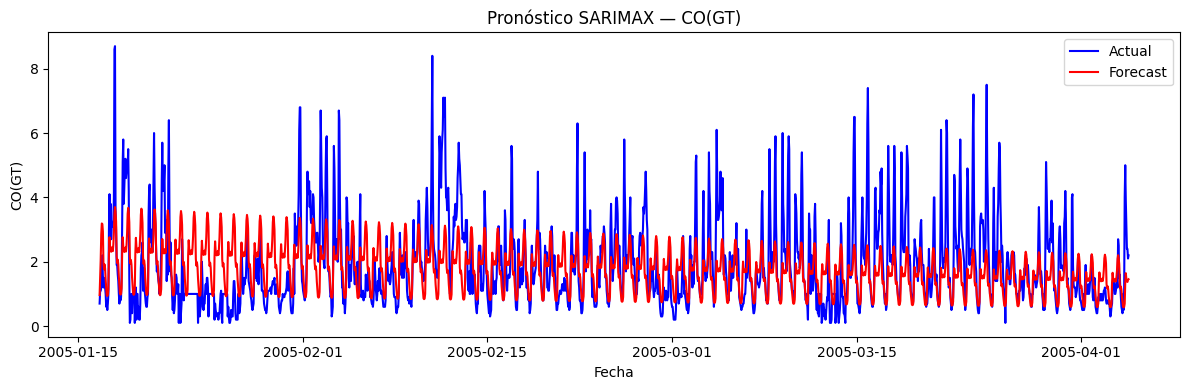

In [104]:
plt.figure(figsize=(12,4))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Pronóstico SARIMAX — CO(GT)')
plt.xlabel('Fecha')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Rango de parámetros
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 24  # estacionalidad diaria (horaria)

# Guardar resultados
mejores_resultados = []
mejor_r2 = -np.inf
mejores_parametros = None

# Grid Search
for order in [(i, j, k) for i in p for j in d for k in q]:
    for seasonal_order in [(i, j, k, s) for i in P for j in D for k in Q]:
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False)
            forecast = fit.forecast(steps=len(test))
            r2 = r2_score(test, forecast)
            mape = mean_absolute_percentage_error(test, forecast)
            mse = mean_squared_error(test, forecast)
            mejores_resultados.append((order, seasonal_order, r2, mape, mse))
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejores_parametros = (order, seasonal_order)
        except:
            continue

# Mostrar mejores parámetros
print("Mejor modelo:")
print("Order:", mejores_parametros[0])
print("Seasonal Order:", mejores_parametros[1])
print(f"R²: {mejor_r2:.3f}")


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

Mejor modelo:
Order: (0, 0, 2)
Seasonal Order: (1, 0, 1, 24)
R²: 0.250


### 2. Modelos neuronales para series de tiempo

- Desarrollar e implementar los siguientes modelos para el pronóstico de la serie:
  - **Multilayer Perceptron (MLP)**
  - **Convolutional Neural Network (CNN)**
  - **Long Short-Term Memory (LSTM)**
  - **Conv-LSTM**

- Implementar cada uno de los modelos anteriores **tanto para el caso univariado como multivariado**.
- Comparar el desempeño de los modelos neuronales **univariados vs. multivariados**.
- Comparar el desempeño de los modelos neuronales **univariados** con el modelo **lineal clásico**. Crear gráficas donde se evidencie la predicción en el conjunto de test tanto del modelo lineal como no lineal

> Seleccionar al menos 3 estructuras de cada modelo. De todo el conjunto de modelos entrenados, seleccionar el modelo que obtuvo mejor rendimiento. A dicho modelo hacer una optimización parámetrica usando optuna. Recuerde que si usa callbacks como `EarlyStopping`, debe configurarse apropiadamente para permitir que el modelo se entrene una cantidad de épocas apropiadas.


In [ ]:
# Preparar la serie
serie = df['CO(GT)'].dropna().values.reshape(-1, 1)

In [9]:
# Escalar los datos
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie)

In [40]:
# ventanas deslizantes
def crear_ventanas(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 24  # 24 horas
X, y = crear_ventanas(serie_scaled, window_size)

In [41]:
# Dividir en train test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [ ]:
# Callback de EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',   # monitorea la pérdida de validación
    patience=5,           # espera 5 épocas sin mejora
    restore_best_weights=True  # restaura los pesos de la mejor época
)

# MLP
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(window_size,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,       
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0058
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0044


In [43]:
# Predicciones 
y_pred = model.predict(X_test)

# Invertir escala 
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

#Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAPE: 0.360
MSE: 0.365
R²: 0.802


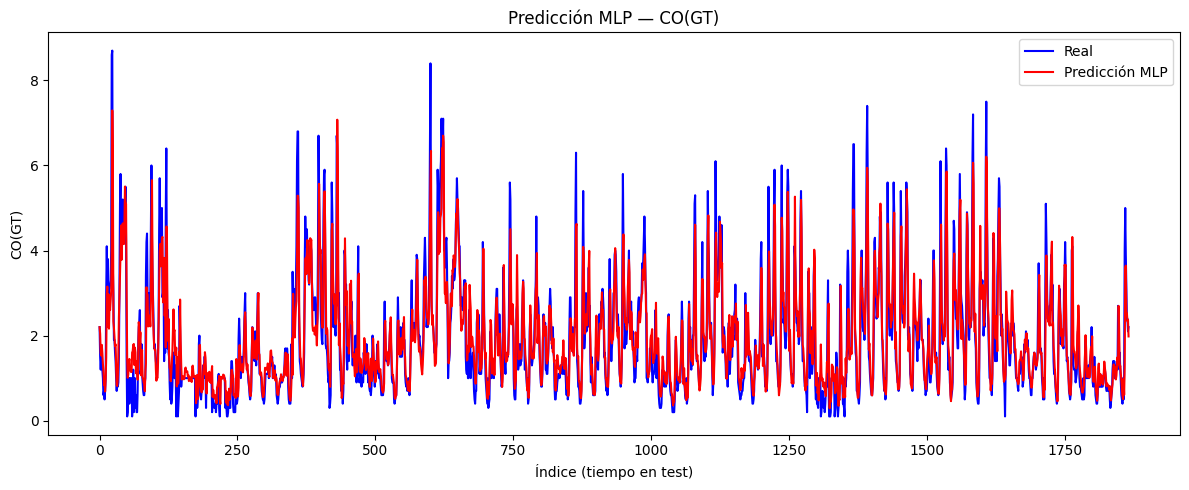

In [44]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(y_pred_inv, label='Predicción MLP', color='red')
plt.title('Predicción MLP — CO(GT)')
plt.xlabel('Índice (tiempo en test)')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


# CNN

In [ ]:
# Redimensionar para CNN 
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train Test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [45]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenamiento con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - val_loss: 0.0051
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - val_loss: 0.0041


In [46]:
#Predicción
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.383
MSE: 0.372
R²: 0.798


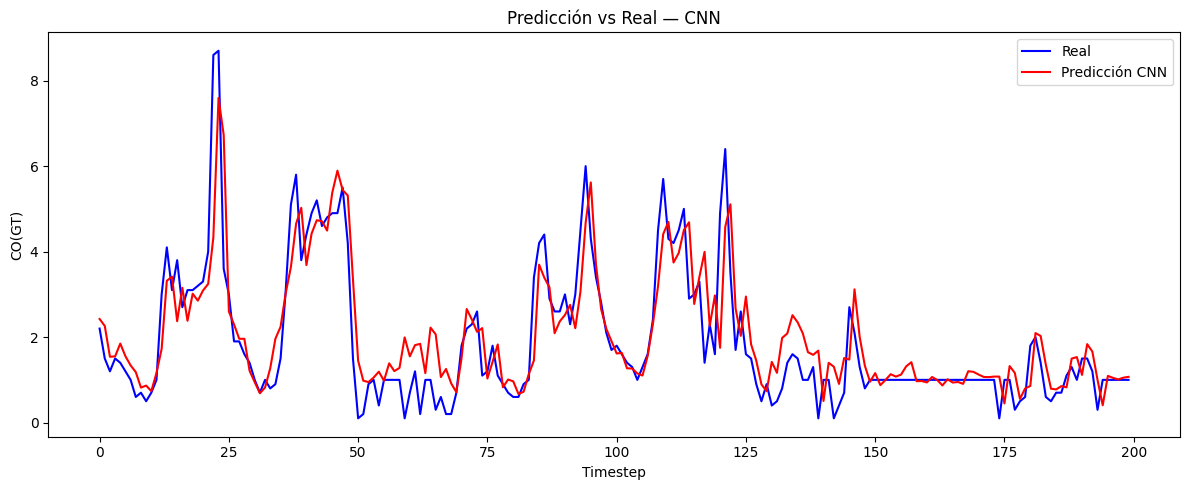

In [47]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN', color='red')
plt.title('Predicción vs Real — CNN')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

# LSTM

In [36]:
# Redimensionar para LSTM 
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [48]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo LSTM
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(window_size, 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0104 - val_loss: 0.0069
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - val_loss: 0.0061
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0051
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_loss: 0.0051
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

In [49]:
# Predecir
y_pred = model.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Calcular métricas
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Mostrar resultados
print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAPE: 0.340
MSE: 0.424
R²: 0.770


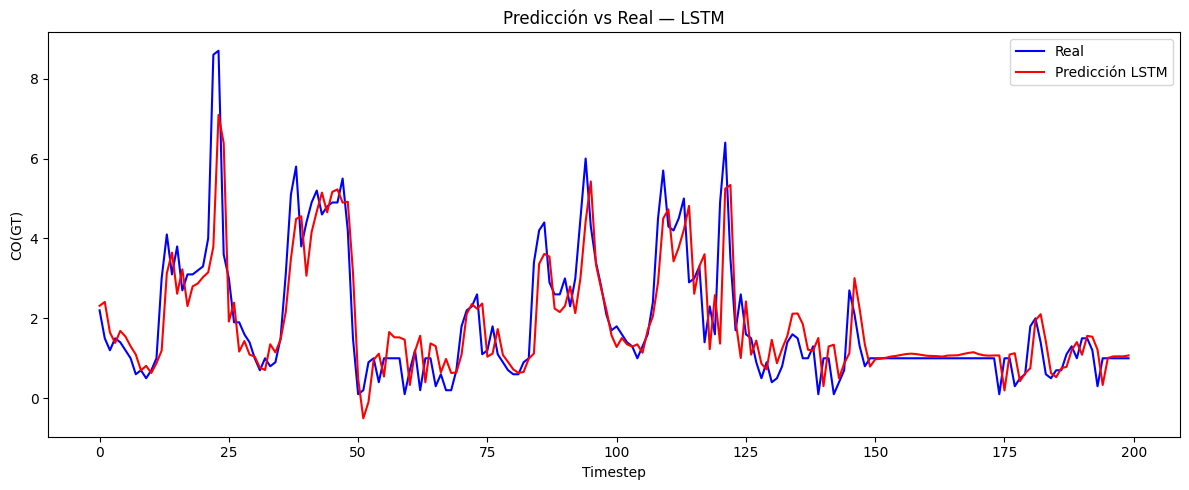

In [51]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción LSTM', color='red')
plt.title('Predicción vs Real — LSTM')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


# CONV-LSTM

In [52]:
# Modelo Conv-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0076 - val_loss: 0.0056
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0050


In [53]:
# Predicción 
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAPE: 0.337
MSE: 0.415
R²: 0.775


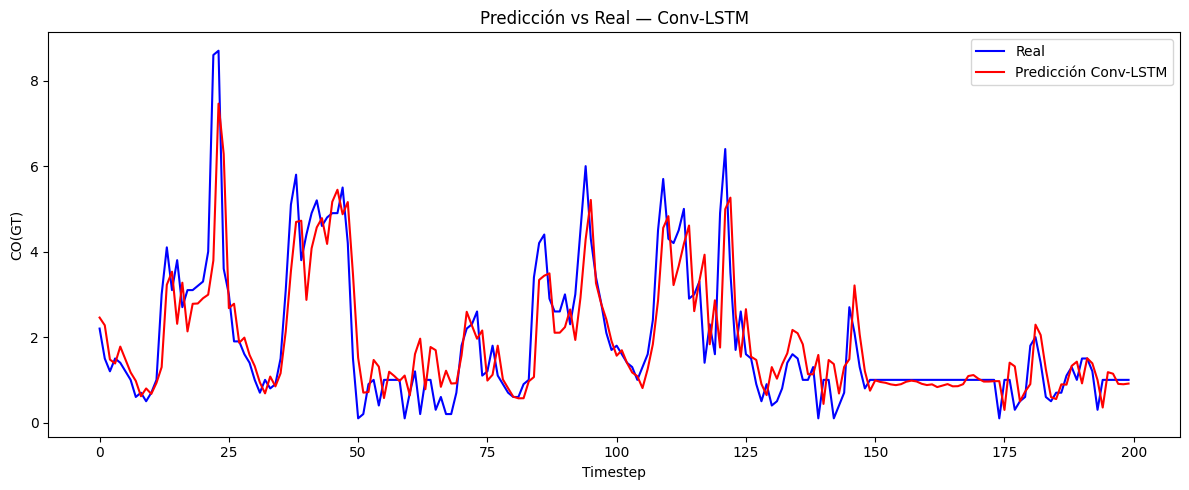

In [54]:
# Gráfica
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción Conv-LSTM', color='red')
plt.title('Predicción vs Real — Conv-LSTM')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


### Resultados:
* SARIMAX: 
MAPE: 0.741
MSE: 1.431
R²: 0.222

Modelo lineal básico. Predicción muy débil y sin capacidad de capturar no linealidades ni picos. Sirve solo como línea base.

* MLP:
MAPE: 0.360
MSE: 0.365
R²: 0.802

El mejor modelo en términos de R². Captura muy bien la dinámica general de la serie con bajo error.

* CNN:
MAPE: 0.383
MSE: 0.372
R²: 0.798

Similar a MLP. Detecta patrones locales, pero ligeramente inferior en precisión.

* LSTM: 
MAPE: 0.340
MSE: 0.424
R²: 0.770

Buena capacidad para modelar secuencias. Mejor MAPE, pero menor R² que MLP. Puede capturar más variabilidad temporal.

* CONV-LSTM:
MAPE: 0.337
MSE: 0.415
R²: 0.775

El mejor MAPE. Combina lo mejor de CNN y LSTM, aunque con menor R² que MLP. Muy buen equilibrio.

Los modelos MLP y Conv-LSTM ofrecen los mejores resultados:

MLP → mayor R² (mejor explicación de la varianza)

Conv-LSTM → menor MAPE (mejor precisión relativa)

Esto demuestra que la serie CO(GT) tiene un comportamiento no lineal complejo que solo los modelos de redes neuronales pueden modelar adecuadamente.